In [1]:
import itertools
from itertools import combinations
from multiprocessing import Pool, cpu_count
import functools
from typing import List, Tuple, Union, Optional, Dict
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.sparse as sp
from scipy.linalg import expm, logm
import sparse
from tqdm import tqdm
import openfermion as of
from openfermion.chem import MolecularData
import openfermionpyscf
from sympy.combinatorics import Permutation 

# Source: https://github.com/aguschanchu/fermionic-mbody
from fermionic_mbody import FixedBasis, rho_m_gen, rho_m

# Constants for STO-3G (H2O)
N_SPIN_ORBITALS = 14
N_ELECTRONS = 10
N_SPATIAL_ORBITALS = N_SPIN_ORBITALS // 2
N_UP = N_ELECTRONS // 2

## Setup

#### H2O Hamiltonian generation (PySCF)

In [2]:
def generate_h2o_hamiltonian(r: float, theta_deg: float = 104.5) -> Tuple[Optional[sp.spmatrix], Optional[MolecularData], MolecularData]:
    """
    Generates the sparse Hamiltonian for the H2O molecule in the STO-3G basis.

    Args:
        r: The O-H bond length in Angstrom.
        theta_deg: The H-O-H bond angle in degrees.
    """
    theta = np.deg2rad(theta_deg)
    x, z = r * np.sin(theta/2), r * np.cos(theta/2)
    geometry = [
        ('O', (0.0, 0.0, 0.0)),
        ('H', ( x, 0.0, z)),
        ('H', (-x, 0.0, z))
    ]
    
    molecule_s = MolecularData(
        geometry=geometry,
        basis='sto-3g',
        multiplicity=1,
        charge=0
    )
    
    try:
        molecule = openfermionpyscf.run_pyscf(
            molecule_s,
            run_scf=1,
            run_mp2=1,
            run_cisd=1,
            run_ccsd=1,
            run_fci=1
        )
    except Exception as e:
        print(f"Warning: PySCF run failed at R={r:.4f}. Error: {e}")
        return None, None, molecule_s

    molecular_hamiltonian = molecule.get_molecular_hamiltonian()
    qubit_hamiltonian = of.jordan_wigner(molecular_hamiltonian)
    sparse_hamiltonian = of.get_sparse_operator(qubit_hamiltonian)
    
    return sparse_hamiltonian, molecule, molecule_s

#### Space helpers

In [3]:
def find_frozen_spin_orbitals(rho1: Union[np.ndarray, sp.spmatrix], occ_thr_core: float = 0.98, occ_thr_virt: float = 0.02) -> Tuple[List[int], List[int], List[int]]:
    """
    Identifies core, virtual, and active spin orbitals based on 1-RDM occupations
    """
    if sp.issparse(rho1):
        occ = np.real(rho1.diagonal())
    else:
        occ = np.real(np.diag(rho1))
        
    idx = np.arange(len(occ))

    core_spin = idx[occ >= occ_thr_core].tolist()
    virt_spin = idx[occ <= occ_thr_virt].tolist()
    active_spin = [p for p in idx if p not in core_spin + virt_spin]
    return core_spin, virt_spin, active_spin

def strip_frozen_orbitals(H_full: Union[sp.spmatrix, np.ndarray],
                          core_spin: List[int],
                          basis: FixedBasis) -> Tuple[Union[sp.spmatrix, np.ndarray], FixedBasis]:
    """
    Projects the Hamiltonian onto a reduced Hilbert space by freezing core orbitals

    Parameters
    ----------
    H_full : Hamiltonian in the canonical determinant basis.
    core_spin : Spin-orbital indices to freeze as always-occupied.
    basis : The FixedBasis object representing the full Fock sector.

    Returns
    -------
    H_active : 2-D matrix
    basis_active : FixedBasis
    """
    n_spin, n_elec = basis.d, basis.m
    k_frozen    = len(core_spin)
    d_active    = n_spin  - k_frozen
    n_active    = n_elec  - k_frozen


    parent = basis

    mask_core = sum(1 << p for p in core_spin)

    keep_full = [i for i, m in enumerate(parent.num_ele)
                 if (m & mask_core) == mask_core]

    # --- active basis ----------------------------------------------------
    basis_active = FixedBasis(d_active, n_active)
    index_active = {m: i for i, m in enumerate(basis_active.num_ele)}

    full2act = []
    core_spin_set = set(core_spin)
    for i in keep_full:
        mask = parent.num_ele[i]
        new_mask = 0
        shift = 0
        for b in range(n_spin):
            if b in core_spin_set:
                shift += 1
            elif mask & (1 << b):
                new_mask |= 1 << (b - shift)
        full2act.append(index_active[new_mask])

    # This reordering ensures the resulting H_active matches the basis_active ordering.
    full2act = np.asarray(full2act)
    H_sub    = H_full[np.ix_(keep_full, keep_full)]
    
    if sp.issparse(H_sub):
        H_active = H_sub[full2act][:, full2act]
    else:
        H_active = H_sub[np.ix_(full2act, full2act)]

    return H_active, basis_active

In [4]:
# Canonical basis 
basis_c = FixedBasis(d=N_SPIN_ORBITALS, num=N_ELECTRONS)

# Restrict to Sz=0 subspace (5 UP, 5 DOWN)
# Using OpenFermion spin convention (even=UP, odd=DOWN)
mask_up_spins = sum(1 << i for i in range(0, N_SPIN_ORBITALS, 2))

idx_equal = []
for idx, ket_mask in enumerate(basis_c.num_ele):
    n_up_in_ket = bin(ket_mask & mask_up_spins).count('1')
    
    if n_up_in_ket == N_UP:
        idx_equal.append(idx)

# Create the restricted basis (Sz=0)
basis_r = FixedBasis.from_subset(basis_c, idx_equal)

# Basis for the UP subsystem (Isomorphic to DOWN subsystem)
basis_up = FixedBasis(d=N_SPATIAL_ORBITALS, num=N_UP)

In [124]:
def split_indices(op: of.FermionOperator, basis_subsystem: FixedBasis) -> Tuple[int, int, int]:
    """
    Decomposes a determinant operator into UP and DOWN components and calculates the fermionic sign
    
    |Det⟩ = sign * |UP⟩⊗|DOWN⟩ in the tensor product basis convention.
    """
    mask_up, mask_dn = 0, 0
    try:
        indices = sorted([p for p, _ in next(iter(op.terms.keys()))])
    except StopIteration:
        raise ValueError("Input operator is empty.")
    
    down_indices = []
    
    for p in indices:
        spatial_idx = p // 2
        if p % 2 == 0: 
            mask_up |= 1 << spatial_idx
        else: 
            mask_dn |= 1 << spatial_idx
            down_indices.append(p)

    # Calculate the fermionic sign (Phase factor)
    # The sign is (-1)^P, where P is the number of swaps required to move all UP operators before DOWN operators.
    sign_power = 0
    for p_dn in down_indices:
        count = sum(1 for p in indices if p > p_dn and p % 2 == 0)
        sign_power += count

    sign = 1 if sign_power % 2 == 0 else -1

    # Find indices in the subsystem basis.
    try:
        mask2idx = basis_subsystem._mask2idx
        i = mask2idx[mask_up]
        j = mask2idx[mask_dn]
    except (AttributeError, KeyError):
        i = int(np.where(basis_subsystem.num_ele == mask_up)[0][0])
        j = int(np.where(basis_subsystem.num_ele == mask_dn)[0][0])
        
    return i, j, sign

# Maps (UP_IDX, DOWN_IDX) -> (index in basis_r, sign)
sub2idx: Dict[Tuple[int, int], Tuple[int, int]] = {} 
for k, op in enumerate(basis_r.base):
    i_up, j_dn, sign = split_indices(op, basis_up)
    sub2idx[(i_up, j_dn)] = (k, sign)

def vect_to_tensor_array(vect: np.ndarray, basis_r: FixedBasis, basis_up: FixedBasis, up: bool = False) -> np.ndarray:
    """
    Converts a state vector or density matrix from the FCI basis (basis_r)
    to the tensor product basis (|UP⟩⊗|DOWN⟩), handling fermionic signs.
    """
    prod_dim = basis_up.size

    if vect.ndim == 1:
        vect = np.outer(vect, vect)

    # We must transform ρ from the FCI basis to the Tensor Product (TP) basis using the signs before tracing.
    reorder = np.empty(prod_dim**2, dtype=int)
    signs = np.empty(prod_dim**2, dtype=float)
    
    for i in range(prod_dim):
        for j in range(prod_dim):
            idx = i * prod_dim + j
            k, sign = sub2idx[(i, j)]
            reorder[idx] = k
            signs[idx] = sign

    rho_perm = np.array(vect[np.ix_(reorder, reorder)])
    
    # ρ_TP = diag(signs) @ ρ_perm @ diag(signs)†
    rho_TP = rho_perm * np.outer(signs, signs)

    rho4D = rho_TP.reshape(prod_dim, prod_dim, prod_dim, prod_dim)
    if up:
        rho_res = np.trace(rho4D, axis1=1, axis2=3)
    else:
        rho_res = np.trace(rho4D, axis1=0, axis2=2)
    return rho_res


## Natural basis rotation (Sparseness optimization)

In [ ]:
def natural_basis_rotation(basis: FixedBasis, rho_1: Optional[Union[np.ndarray, sparse.COO]] = None, U: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Calculates the basis transformation matrix V corresponding to a
    single-particle rotation U (V_IJ = det(U[I, J]))
    """
    if U is None:
        if rho_1 is None:
            raise ValueError("Either rho_1 or U must be provided.")
            
        if hasattr(rho_1, 'todense'):
             rho_1_dense = rho_1.todense()
        else:
             rho_1_dense = np.asarray(rho_1)

        # Calculate natural orbitals
        evals, evects = scipy.linalg.eigh(rho_1_dense)
        U = evects[:, ::-1]

    d = basis.d
    occupied_indices_list = []
    for mask in basis.num_ele:
        indices = [i for i in range(d) if (mask >> i) & 1]
        occupied_indices_list.append(indices)
    
    levels = np.array(occupied_indices_list)

    row_indices = levels[:, np.newaxis, :, np.newaxis]
    col_indices = levels[np.newaxis, :, np.newaxis, :]

    submatrices = U[row_indices, col_indices]
    V = np.linalg.det(submatrices)
    
    return V

In [ ]:
"""
Optimization Setup
"""
# Obtain Hamiltonian at the dissociated limit 
R_dissociation = 3.0
h_gc, _, _ = generate_h2o_hamiltonian(R_dissociation)

if h_gc is None:
    # Try perturbing slightly if it failed
    h_gc, _, _ = generate_h2o_hamiltonian(R_dissociation + 1e-4*np.random.random())
    if h_gc is None:
        raise RuntimeError(f"Hamiltonian generation failed at R={R_dissociation}")

# Project Hamiltonian onto Sz=0 basis
H_r = h_gc[np.ix_(basis_r.num_ele, basis_r.num_ele)].real

# Find the ground state
e, v = scipy.sparse.linalg.eigsh(H_r, k=1, which='SA', tol=1e-8)
fund = v[:, 0]

# Decompose the ground state 
C = vect_to_tensor_array(fund, basis_r, basis_up)

# Calculate subsystem density matrices
rho_1_arrays = rho_m_gen(basis_up, 1)
rho_up = C @ C.T.conj()
rho_down = C.T.conj() @ C
rho_1_up = rho_m(rho_up, rho_1_arrays)
rho_1_down = rho_m(rho_down, rho_1_arrays)

# Calculate the rotation to the Natural Orbital (NO) basis
V_up = natural_basis_rotation(basis_up, rho_1=rho_1_up)
V_down = natural_basis_rotation(basis_up, rho_1=rho_1_down)

# Rotate C to the NO basis
Cn = V_up.T.conj() @ C @ V_down

ρ_1 (V3.1 Numba): 100%|██████████| 35/35 [00:00<00:00, 1895.60it/s]


In [ ]:
# Optimization Helpers

def rho_to_seed(rho_1: Union[np.ndarray, sparse.COO]) -> np.ndarray:
    """Generates an optimization seed corresponding to the natural orbital rotation."""
    if hasattr(rho_1, 'todense'):
         rho_1_dense = rho_1.todense()
    else:
         rho_1_dense = np.asarray(rho_1)

    evals, evects = scipy.linalg.eigh(rho_1_dense)
    U = evects[:, ::-1]
    
    if np.linalg.det(U) < 0:
        U[:, -1] *= -1
        
    return encode(U)

def encode(U: np.ndarray) -> np.ndarray:
    """Encodes an orthogonal matrix U into parameters of the generating antisymmetric matrix A (U = exp(A))."""
    A = logm(U)
    A = 0.5 * (A - A.T) 
    triu_indices = np.triu_indices(U.shape[0], k=1)
    params = A[triu_indices].real
    return params

def decode(params: np.ndarray) -> np.ndarray:
    """Decodes parameters into an orthogonal matrix U = exp(A)."""
    n = int((1 + np.sqrt(1 + 8 * len(params))) // 2)
    A = np.zeros((n, n))
    triu_indices = np.triu_indices(n, k=1)
    A[triu_indices] = params
    A -= A.T
    U = expm(A)
    return U

# Cost functions

def hoyer_sparsity(c: np.ndarray) -> float:
    """Calculates the Hoyer sparsity measure (0=dense, 1=sparse)."""
    n = c.size
    if n <= 1: return 1.0
    
    c_flat = c.flatten()
    L1 = np.sum(np.abs(c_flat))
    L2 = np.sqrt(np.sum(np.abs(c_flat)**2))
    
    if L2 < 1e-12: return 1.0 # Handle zero vector
        
    return (np.sqrt(n) - L1 / L2) / (np.sqrt(n) - 1)

def l0_combined(C: np.ndarray, threshold=1e-3, alpha=0.1, beta=1.0, temperature=0.01) -> float:
    """Calculates a combined L1 and smoothed L0 norm cost function."""
    abs_C = np.abs(C)
    L1 = np.sum(abs_C)
    # Smoothed L0 norm using sigmoid
    sigmoid_mask = 1 / (1 + np.exp(-(abs_C - threshold) / temperature))
    smoothed_L0 = np.sum(sigmoid_mask)
    
    return alpha * L1 + beta * smoothed_L0

def loss(C: np.ndarray) -> float:
    """Selected loss function to minimize (maximize sparsity)."""
    return l0_combined(C)

def opti_fun(seed: np.ndarray, C_ref: np.ndarray, basis_sub: FixedBasis) -> float:
    """Optimization objective function"""
    half_len = len(seed) // 2
    params_up, params_down = seed[:half_len], seed[half_len:]
    
    U_up, U_down = decode(params_up), decode(params_down)
    V_up = natural_basis_rotation(basis_sub, U=U_up)
    V_down = natural_basis_rotation(basis_sub, U=U_down)
    
    # Rotate the coefficient matrix
    Ce = V_up.T.conj() @ C_ref @ V_down.conj()
    return loss(Ce)

# Calculate seed
seed_up = rho_to_seed(rho_1_up)
seed_down = rho_to_seed(rho_1_down)
init_seed = np.concatenate([seed_up, seed_down])

# Main optimization
print("Starting basis optimization...")
opt_m = scipy.optimize.basinhopping(
    opti_fun,
    init_seed,
    minimizer_kwargs={
        "method":"L-BFGS-B",
        "options":{"disp": True},
        "args": (C, basis_up) 
    },
)

# Rotate the state
seed = opt_m.x
params_up, params_down = seed[:len(seed)//2], seed[len(seed)//2:]
U_up, U_down = decode(params_up), decode(params_down)
Vop_up = natural_basis_rotation(basis_up, U=U_up)
Vop_down = natural_basis_rotation(basis_up, U=U_down)
Cop = Vop_up.T.conj() @ C @ Vop_down

loss(C), loss(Cn), loss(Cop)

Starting basis optimization...


## Dissociation curve analysis

#### Restricted RDM arrays generation

In [ ]:
"""
Arrays blocks computation
"""

def _extract_sparse_block(arr: sparse.COO, row_terms: np.ndarray, col_terms: np.ndarray) -> sparse.COO:
    """Extracts a sub-block from a sparse COO tensor and remaps indices."""
    if not isinstance(row_terms, np.ndarray): row_terms = np.array(row_terms)
    if not isinstance(col_terms, np.ndarray): col_terms = np.array(col_terms)

    row_mask = np.isin(arr.coords[0], row_terms)
    col_mask = np.isin(arr.coords[1], col_terms)
    keep = row_mask & col_mask

    coords = arr.coords[:, keep]
    data   = arr.data[keep]

    # Remap indices
    row_map = {old: new for new, old in enumerate(row_terms)}
    col_map = {old: new for new, old in enumerate(col_terms)}
    
    coords[0] = np.vectorize(row_map.get)(coords[0])
    coords[1] = np.vectorize(col_map.get)(coords[1])

    shape = (len(row_terms), len(col_terms), arr.shape[2], arr.shape[3])
    return sparse.COO(coords, data, shape)


def rho2_block_antisym(basis: FixedBasis, rho2_full: Optional[sparse.COO] = None, upup: bool = True) -> sparse.COO:
    """
    Extracts spin-specific blocks of the 2-RDM generator tensor in the antisymmetrized basis
    """
    if rho2_full is None:
        rho2_full = rho_m_gen(basis, 2)

    t_basis = FixedBasis(basis.d, 2)
    terms   = []
    
    for idx, mask in enumerate(t_basis.num_ele):
        p = int(np.log2(int(mask) & -int(mask)))
        q = int(np.log2(int(mask) ^ (1 << p)))

        p_spin, q_spin = p % 2, q % 2

        if upup:
            # Same spin (UPUP or DNDN)
            if p_spin == q_spin:
                terms.append(idx)
        else:
            # Opposite spin (UPDOWN)
            if p_spin != q_spin:
                terms.append(idx)

    return _extract_sparse_block(rho2_full, terms, terms)

# --- Ordered Blocks ---

def so_idx(spatial: int, spin: int) -> int:
    """Maps spatial orbital index and spin (0=↑, 1=↓) to spin-orbital index"""
    return 2*spatial + spin

def _rho2_ext_worker(chunk, basis: FixedBasis, sig: int, tau: int):
    """
    Worker function for rho2_block_ordered
    """
    coords, vals = [], []
    d = basis.d // 2
    n_qubits = basis.d
    
    # Pre-fetch basis indices for slicing
    basis_indices = basis.num_ele

    for i, j, k, l in chunk:
        i, j, k, l = map(int, (i, j, k, l))

        # Operator: c†_{k,sig} c†_{l,tau} c_{j,tau} c_{i,sig}
        op_str = (
            (so_idx(k, sig), 1), (so_idx(l, tau), 1),
            (so_idx(j, tau), 0), (so_idx(i, sig), 0)
        )
        op = of.FermionOperator(op_str)

        # Calculate matrix representation in the full Fock space (computationally expensive)
        mat = of.get_sparse_operator(op, n_qubits=n_qubits)
        mat_restricted = mat[basis_indices, :][:, basis_indices].real
            
        r, c = mat_restricted.nonzero()
        row, col = i * d + j, k * d + l
        for rr, cc, vv in zip(r, c, mat_restricted.data):
            coords.append([row, col, rr, cc])
            vals.append(vv)
    return coords, vals

def rho2_block_ordered(basis: FixedBasis, upup: bool = True, n_workers: Optional[int] = None) -> sparse.COO:
    """
    Generates the 2-RDM generator tensor in an ordered (non-antisymmetrized) basis of spatial orbitals.
    Shape (d_spatial², d_spatial², N_dim, N_dim).
    """
    if n_workers is None:
        n_workers = max(1, cpu_count()//2)

    d = basis.d // 2
    shape = (d**2, d**2, basis.size, basis.size)

    if upup:
        spin_cases = [(0, 0)] # ↑↑ (or ↓↓)
    else:
        spin_cases = [(0, 1)] # ↑↓

    work = list(itertools.product(range(d), repeat=4))
    chunks = np.array_split(work, n_workers)

    coords, vals = [], []
    desc = f"ρ₂-ordered ({'↑↑' if upup else '↑↓'})"

    for sig, tau in spin_cases:
        if n_workers == 1:
            for chunk in tqdm(chunks, desc=desc):
                c, v = _rho2_ext_worker(chunk, basis, sig, tau)
                coords.extend(c); vals.extend(v)
        else:
            with Pool(n_workers) as pool:
                jobs = ((chunk, basis, sig, tau) for chunk in chunks)
                results = pool.starmap(_rho2_ext_worker, jobs)
                for c, v in tqdm(results, total=len(chunks), desc=desc):
                    coords.extend(c); vals.extend(v)

    if not coords:
        return sparse.COO([], [], shape=shape)
        
    coords_T = np.asarray(coords).T
    return sparse.COO(coords_T, vals, shape=shape)

def partial_transpose(rho: np.ndarray, perm: List[int], d: Optional[int] = None) -> np.ndarray:
    """
    Performs a permutation of indices (e.g., partial transpose) on a matrix (d² x d²).

    Args:
        rho: The density matrix (d² x d²).
        perm: The permutation of axes for the reshaped tensor.
        d: The dimension of the subsystems. 
    """
    rho = np.asarray(rho)
    
    if d is None:
        d = int(np.sqrt(rho.shape[0]))
        if d*d != rho.shape[0]:
            raise ValueError("Input matrix must be square with dimension d².")
    
    rho_tensor = rho.reshape((d, d, d, d))
    rho_permuted_tensor = rho_tensor.transpose(np.argsort(perm))
    rho_p = rho_permuted_tensor.reshape((d**2, d**2))
    
    return rho_p

#### States computation

In [ ]:
# RDM Array Generation
rho_1_extended = rho_m_gen(basis_r, 1)
rho_2_extended = rho_m_gen(basis_r, 2)
rho_2_extended_upup_as = rho2_block_antisym(basis_r, rho_2_extended, upup=True)
rho_2_extended_updown_as = rho2_block_antisym(basis_r, rho_2_extended, upup=False)
rho_2_extended_upup = rho2_block_ordered(basis_r, upup=True)
rho_2_extended_updown = rho2_block_ordered(basis_r, upup=False)

In [ ]:
import scipy.sparse.linalg
from typing import Dict

def calculate_dissociation_curve(dists: np.ndarray, 
                                 basis_r: FixedBasis, 
                                 state_type: str = 'gs', 
                                 level: int = 0, 
                                 BETA: float = 1000.0,
                                 degeneracy_tol: float = 1e-6) -> Dict[float, Union[np.ndarray, np.ndarray]]:
    """
    Calculates the specified energy level (GS or excited) or thermal state.
    Handles degeneracies by returning a density matrix (normalized projector) if the level is degenerate.
    """
    states = {}
    prev_vecs = None 
    print(f"Calculating dissociation curve (Type: {state_type}, Level: {level})...")
    
    # Request slightly more states than needed to improve stability near crossings
    k_extra = 1 if level != 0 else 0
    k_request = level + 1 + k_extra

    for R in tqdm(dists, desc="R"):
        R = float(R)
        
        # Generate Hamiltonian 
        H_full, *_ = generate_h2o_hamiltonian(R)
        if H_full is None:
            H_full, *_ = generate_h2o_hamiltonian(R + 1e-4 * np.random.random())
            if H_full is None:
                print(f"Skipping R={R:.4f}.")
                continue

        # Project Hamiltonian
        H = H_full[np.ix_(basis_r.num_ele, basis_r.num_ele)].real

        # Calculate State
        if state_type == 'gs':
            k_eff = min(k_request, H.shape[0] - 1)
            if k_eff <= 0: continue

            try:
                # Use the previous vector corresponding to the level as the initial guess 
                v0 = prev_vecs[:, level] if prev_vecs is not None and prev_vecs.shape[1] > level else None

                # Increase ncv (Number of Lanczos vectors) for better convergence 
                ncv = max(2 * k_eff + 5, min(H.shape[0] - 1, 40))

                E, V = scipy.sparse.linalg.eigsh(H, k=k_eff, which='SA', v0=v0, tol=1e-10, ncv=ncv)
                
                if len(E) <= level:
                    print(f"Warning: Fewer states ({len(E)}) found than requested level ({level}) at R={R:.4f}.")
                    continue

                # Sort results 
                sort_idx = np.argsort(E)
                E = E[sort_idx]
                V = V[:, sort_idx]

                # Update initial guesses 
                norms = np.linalg.norm(V, axis=0)
                valid_mask = norms > 1e-9
                if np.any(valid_mask):
                   V_norm = V[:, valid_mask] / norms[valid_mask]
                   prev_vecs = V_norm
                
                # --- Degeneracy Handling ---
                target_energy = E[level]
                # Identify all states within the tolerance
                degenerate_indices = np.where(np.abs(E - target_energy) < degeneracy_tol)[0]
                
                if len(degenerate_indices) > 1:
                    # Create the projector (normalized density matrix)
                    V_subspace = V[:, degenerate_indices]
                    D = V_subspace.shape[1]
                    # ρ = (1/D) * V @ V†
                    rho_projector = (V_subspace @ V_subspace.conj().T) / D
                    states[R] = rho_projector
                else:
                    # Non-degenerate state 
                    states[R] = V[:, level]

            except (scipy.sparse.linalg.ArpackNoConvergence, scipy.sparse.linalg.ArpackError) as e:
                print(f"Warning: Eigensolver failed at R={R:.4f} for level {level}. Skipping. Error: {e}")
                prev_vecs = None # Clear guesses if failed
                continue

        elif state_type == 'thermal':
            H_dense = H.todense() if hasattr(H, 'todense') else H
            E, V = np.linalg.eigh(H_dense)
            weights = np.exp(-BETA * (E - E.min()))
            weights /= weights.sum()
            rho_thermal = V @ np.diag(weights) @ V.conj().T
            states[R] = rho_thermal
        else:
            raise ValueError(f"Unknown state_type: {state_type}.")

    return states

dists = np.linspace(0.1, 4.0, 50)
states = calculate_dissociation_curve(dists, basis_r, state_type='gs', level = 0)
#states = calculate_dissociation_curve(dists, basis_r, state_type='thermal')

Calculating dissociation curve (Type: thermal, Level: 0)...


R:  86%|████████▌ | 43/50 [04:43<01:23, 11.95s/it]

R: 100%|██████████| 50/50 [05:45<00:00,  6.91s/it]


#### Plots

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 402.26it/s]


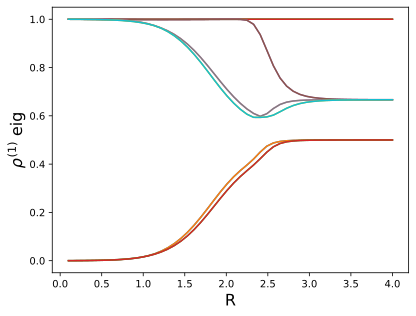

100%|██████████| 50/50 [00:00<00:00, 84.00it/s]


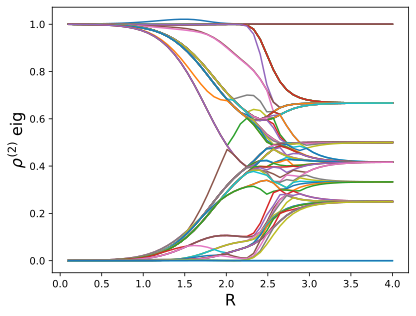

100%|██████████| 50/50 [00:00<00:00, 202.45it/s]


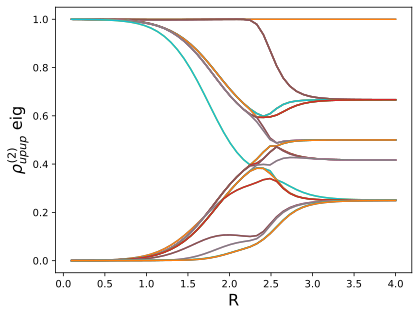

100%|██████████| 50/50 [00:00<00:00, 135.42it/s]


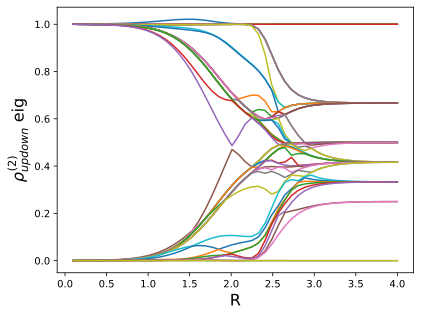

100%|██████████| 50/50 [00:00<00:00, 98.23it/s]


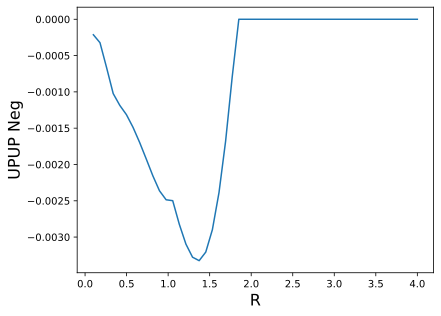

100%|██████████| 50/50 [00:00<00:00, 119.99it/s]


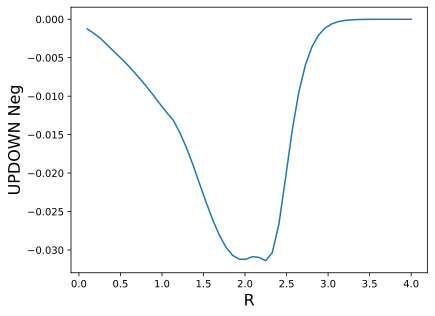

100%|██████████| 50/50 [00:00<00:00, 127.47it/s]


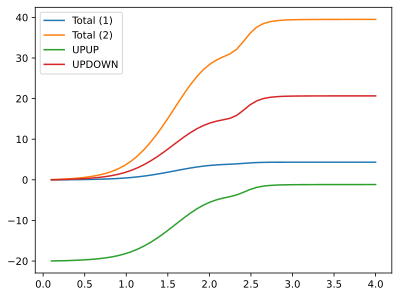

100%|██████████| 50/50 [00:00<00:00, 52.10it/s]


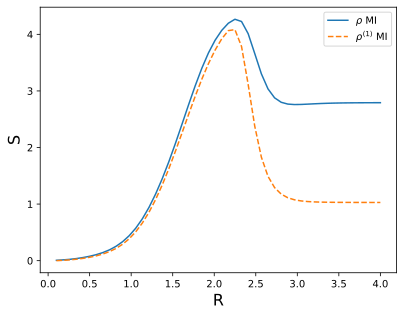

In [125]:
import matplotlib.pyplot as plt

def S_vn(rho: np.ndarray) -> float:
    """
    Calculates the von Neumann entropy S = -Tr(ρ_norm log2(ρ_norm))
    """
    eigvals = np.linalg.eigvalsh(rho)
    
    trace = np.sum(eigvals)
    if abs(trace) < 1e-9:
        return 0.0
        
    eigvals = eigvals[eigvals > 1e-12]
    
    return -np.sum(eigvals * np.log2(eigvals))

def plot_rho(states_dict: dict, rho_arrays: sparse.COO, label: str = r'$\rho^{(m)}$ eig'):
    """Calculates and plots the eigenvalues of the m-RDM."""
    ds = sorted(list(states_dict.keys()))
    if not ds: return None
        
    res = np.zeros(shape=(len(ds),rho_arrays.shape[0]))
    
    for idx, d in tqdm(enumerate(ds), total=len(ds)):
        state = states_dict[d]
        rho = rho_m(state, rho_arrays)
        rho_dense = rho.todense() if hasattr(rho, 'todense') else rho
        
        # Use eigvalsh and sort descending
        eigvals = np.linalg.eigvalsh(rho_dense)
        res[idx] = np.sort(eigvals)[::-1]

    plt.figure()
    plt.plot(ds, res)
    plt.xlabel(r'R', fontsize=16) 
    plt.ylabel(label, fontsize=16)
    plt.show()
    return res

def m_entropy(states_dict: dict, rho_arrays: sparse.COO) -> np.ndarray:
    """Calculates the m-body entropy S(ρ(m))."""
    ds = sorted(list(states_dict.keys()))
    res = np.zeros(shape=(len(ds)))
    
    for idx, d in tqdm(enumerate(ds), total=len(ds)):
        state = states_dict[d]
        rho = rho_m(state, rho_arrays)
        rho_dense = rho.todense() if hasattr(rho, 'todense') else rho
        res[idx] = S_vn(rho_dense)

    return res

def plot_neg(states_dict: Dict[float, np.ndarray], 
             rho_arrays: sparse.COO, 
             label: str = r'SNE', 
             second: bool = False, 
             normalize: bool = True):
    """
    Calculates and plots the Sum of Negative Eigenvalues (SNE) of the partially transposed 2-RDM block.

    Args:
        states_dict: Dictionary of states.
        rho_arrays: The RDM generator tensor (ordered block).
        label: Plot label.
        second: If True, applies the specific fermionic PT definition (PT1 - PT2), used for UPUP.
        normalize: If True (default), normalizes the RDM to Tr=1 before calculation.
    """
    ds = sorted(list(states_dict.keys()))
    if not ds: return None

    res = np.zeros(shape=(len(ds)))
    d_sub = int(np.sqrt(rho_arrays.shape[0]))

    # Permutations 
    perm_main = [0, 3, 2, 1]
    perm_second = [0, 2, 3, 1]

    for idx, R in tqdm(enumerate(ds), total=len(ds)):
        state = states_dict[R]
        
        # Calculate the RDM block
        rho = rho_m(state, rho_arrays)
        rho_dense = rho.todense() if hasattr(rho, 'todense') else np.asarray(rho)
        
        if normalize:
            trace_val = np.trace(rho_dense).real
            if abs(trace_val) > 1e-9:
                rho_dense = rho_dense / trace_val
            else:
                continue

        # Apply Partial Transpose combinations
        rho_pt = partial_transpose(rho_dense, perm_main, d=d_sub)
        if second:
             rho_pt -= partial_transpose(rho_dense, perm_second, d=d_sub)

        eigvals = np.linalg.eigvals(rho_pt)
        sne = np.sum([x.real for x in eigvals if x.real < -1e-12])
        res[idx] = sne

    plt.figure()
    plt.plot(ds, res)
    plt.xlabel(r'R', fontsize=16)
    plt.ylabel(label, fontsize=16)
    plt.show()
    return res

def plot_density_up(states_dict: dict):
    """Plots the eigenvalues of the reduced density matrix ρ_UP (for thermal states)."""    
    prod_dim = basis_up.size
    ds = sorted(list(states_dict.keys()))
    res = np.zeros(shape=(len(ds), basis_up.size))

    for idx, R in tqdm(enumerate(ds), total=len(ds)):
        rho = np.array(states_dict[R])        
        rho_up = vect_to_tensor_array(rho, basis_r, basis_up, up=True)

        eigvals = np.linalg.eigvalsh(rho_up)
        res[idx] = np.sort(eigvals)[::-1]

    plt.figure()
    plt.plot(ds, res)
    plt.xlabel(r'R', fontsize=16)
    plt.ylabel( r'$\rho_{UP}$ eig', fontsize=16)
    plt.show()
    return res

def plot_mutual_information(states_dict: dict):
    """
    Plots the mutual information of states and RDM
    Check the document for the corrert normalization
    """    
    ds = sorted(list(states_dict.keys()))
    res_d, res_rho = np.zeros(shape=(len(ds))), np.zeros(shape=(len(ds)))

    for idx, R in tqdm(enumerate(ds), total=len(ds)):
        rho = states_dict[R]
        if rho.ndim == 1:
            rho = np.outer(rho, rho)

        # Calculate UP/DOWN density matrix (partial trace)
        rho_up = vect_to_tensor_array(rho, basis_r, basis_up, up = True)
        rho_down = vect_to_tensor_array(rho, basis_r, basis_up, up = False)

        # Calculate 1,2-RDM
        rho_1_up = rho_m(rho_up, rho_1_arrays).todense()
        rho_1_up *= np.trace(rho_1_up)
        rho_1_down = rho_m(rho_down, rho_1_arrays).todense()
        rho_1_down *= np.trace(rho_1_down)
        rho_2_updown = rho_m(rho, rho_2_extended_updown_as).todense()

        res_d[idx] = S_vn(rho_up)*np.trace(rho_up) + S_vn(rho_down)*np.trace(rho_down) - S_vn(rho)
        res_rho[idx] = S_vn(rho_1_up) + S_vn(rho_1_down) - S_vn(rho_2_updown)

    plt.figure()
    plt.plot(ds, res_d, label=r'$\rho$ MI')
    plt.plot(ds, res_rho-res_rho[0], linestyle='dashed', label=r'$\rho^{(1)}$ MI')
    plt.xlabel(r'R', fontsize=16)
    plt.ylabel( r'S', fontsize=16)
    plt.legend()
    plt.show()


# RDM Eigenvalues
plot_rho(states, rho_1_extended, label = r'$\rho^{(1)}$ eig')
plot_rho(states, rho_2_extended, label = r'$\rho^{(2)}$ eig')
plot_rho(states, rho_2_extended_upup_as, label = r'$\rho^{(2)}_{upup}$ eig')
plot_rho(states, rho_2_extended_updown_as, label = r'$\rho^{(2)}_{updown}$ eig')
plot_neg(states, rho_2_extended_upup, label = r'UPUP Neg', second = True)
plot_neg(states, rho_2_extended_updown, label = r'UPDOWN Neg')

# M-entropy
ds = list(states.keys())
plt.plot(ds, m_entropy(states, rho_1_extended),label='Total (1)')
plt.plot(ds, m_entropy(states, rho_2_extended),label='Total (2)')
plt.plot(ds, m_entropy(states, rho_2_extended_upup), label='UPUP')
plt.plot(ds, m_entropy(states, rho_2_extended_updown), label='UPDOWN')
plt.legend()
plt.show()

# Mutual information
plot_mutual_information(states)


## Análisis H

In [10]:
# Generamos el H para d=4
H_sparse, molecule, molecule_s = generate_h2o_hamiltonian(4)
# Restringimos a la base canónica
H_sparse = H_sparse[np.ix_(basis_c.num_ele, basis_c.num_ele)].real

In [11]:
# Filtramos a los estados que tengan igual número de electrones UP / DOWN
idx_equal = [
    idx for idx, ket in enumerate(basis_c.base)
    if sum(p % 2 == 0 for p, _ in next(iter(ket.terms.keys()))) == 5
]

H = H_sparse[np.ix_(idx_equal, idx_equal)].todense()
# Guardamos la base restringida
basis_r = FixedBasis.from_subset(basis_c, idx_equal)
rho_1_arrays_r = rho_1_extended
rho_2_arrays_r = rho_2_extended

In [12]:
# Veamos los primeros autovalores
eigvals, eigvects = np.linalg.eigh(H)
# Levantamos el autoespacio fundamental
tol = 1e-2
idx = np.where(eigvals < min(eigvals)+tol)
dimension = len(idx[0])
eigen_space = eigvects[:,idx[0]] # Las columnas de eigen_space son las distintos estados fundamentales en basis_r (441, 12)

Verificamos que el autoespacio tenga el spin correcto

In [ ]:
import openfermion as of
import numpy as np
from scipy.sparse.linalg import eigsh
bbb = basis_r

# This assumes you have num_orbitals, num_electrons already defined
sz_op = of.hamiltonians.sz_operator(bbb.d//2)
s2_op = of.hamiltonians.s_squared_operator((1+bbb.d)//2)

sz_op = of.get_sparse_operator(sz_op, n_qubits=bbb.d)[np.ix_(bbb.num_ele, bbb.num_ele)]
s2_op = of.get_sparse_operator(s2_op, n_qubits=bbb.d)[np.ix_(bbb.num_ele, bbb.num_ele)]

for i in range(eigen_space.shape[1]):
    state = eigen_space[:,i]
    exp_S2 = np.real(state.conj().T @ (s2_op @ state))
    exp_Sz = np.real(state.conj().T @ (sz_op @ state))
    print(f"Estado {i}: <S^2> = {float(exp_S2):.4f}, <S_z> = {float(exp_Sz):.4f}")


##### Subespacio pureza nula

Utilizamos L-BFGS-B para buscar mínimos locales, a partir de distintas semillas. Con una colección de estos, nos fijamos el rango de subespacio

In [13]:
def purity(coefs):
    vect = np.asarray(eigen_space @ coefs).ravel()   
    vect /= np.linalg.norm(vect)
    rho_1 = rho_m(vect, rho_1_arrays_r).todense()
    return basis_r.m-np.trace(np.linalg.matrix_power(rho_1, 2))

maxiter = 50
local_minima_arr = []

for i in tqdm(range(maxiter)):
    seed = np.random.uniform(-1,1,dimension)
    seed *= 1/np.linalg.norm(seed)
    opt = scipy.optimize.minimize(purity, seed, method="SLSQP", constraints={'type':'eq', 'fun': lambda c: c@c-1})
    if purity(opt.x) < 1e-4:
        local_minima_arr.append(opt.x)

local_minima_arr = np.array(local_minima_arr).T # [:, i] i-esimo vector
U, S, Vh  = np.linalg.svd(local_minima_arr)
idx = np.where(S > 1e-2)
purity_dim = len(idx[0])
purity_space = U[:,idx[0]] # purity_space[:, i] i-ésimo generador en la base eigen_space (12, 6)


100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


Dado purity_space, existe una base ortonormal que la genere también?

In [20]:
# Buscamos el espacio ortonormal
Q, R = np.linalg.qr(purity_space)
diag_R = np.abs(np.diag(R))
rank   = np.sum(diag_R > 1e-12)
purity_space_ort = Q[:, :rank] # base ortonormal de purity_space escrita en eigen_space

n, k = purity_space_ort.shape
tri_u = np.triu_indices(k, 1)         
n_free = len(tri_u[0])                 

"""
Vía QR, obtuvimos un conjunto de generadores ortonormales de purity_space. En principio, no tienen porque ser DS
Procedemos buscando transformaciones unitarias que hagan que el conjunto de generadores tenga pureza mínima
"""

# Parametrización del la antisimétrica (exponente)
def param_to_A(theta: np.ndarray) -> np.ndarray:
    A = np.zeros((k, k), dtype=float)
    A[tri_u] = theta
    A[(tri_u[1], tri_u[0])] = -theta 
    return A                           

# Devuelve las coordenadas de un vector en la base de pureza, a basis_r
def purity_to_basis(coefs):
    vect = np.asarray(eigen_space @ coefs).ravel()   
    vect /= np.linalg.norm(vect)
    return vect

# Pureza del conjunto
def loss(coefs, fun):
    res = 0
    for j in range(purity_space_ort.shape[1]):
        vect = fun(coefs[:,j])
        rho_1 = rho_m(vect, rho_1_arrays_r).todense()
        res += basis_r.m-np.trace(np.linalg.matrix_power(rho_1, 2))
    return res

# Función a minimizar
def total_purity(theta: np.ndarray, B: np.ndarray, fun) -> float:
    A = param_to_A(theta)
    U = scipy.linalg.expm(A)           
    rot_gen = B @ U
    return loss(rot_gen, fun)

theta0 = np.zeros(n_free)                              

res = scipy.optimize.minimize(
    total_purity,
    theta0,
    args=(purity_space_ort,purity_to_basis,),
    method="BFGS",
    options=dict(disp=True, maxiter=2000),
)
res


Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 1
         Function evaluations: 48
         Gradient evaluations: 3


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.4277747784063877e-06
        x: [-1.943e-05 -1.665e-05 ...  1.490e-08 -2.681e-05]
      nit: 1
      jac: [-2.384e-07 -1.192e-07 ...  7.153e-07 -1.192e-07]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 48
     njev: 3

Comprobamos que ambos proyectores coincidan

In [17]:
A_opt  = param_to_A(res.x)          
U_opt  = scipy.linalg.expm(A_opt) 
coeffs_rot = purity_space_ort @ U_opt      
purity_kets   = eigen_space @ coeffs_rot 

In [18]:
vect_unif = np.sum([1/np.sqrt(purity_dim) * purity_kets[:,j] for j in range(purity_dim)], axis=0).reshape(-1)
au = lambda x: np.sort(np.linalg.eigvals(x.todense()))

au(rho_m(vect_unif, rho_1_arrays_r))


array([0.49854606, 0.49885552, 0.49981124, 0.49989497, 0.50010505,
       0.50018876, 0.50114451, 0.50145398, 0.99999996, 0.99999997,
       0.99999998, 0.99999999, 1.        , 1.        ])

In [250]:
vect = np.zeros(441**2)
B = np.kron(E,E)
for i in range(441**2):
    for j in range(12**2):
        vect += B[i,0] * np.kron(basis_r.canonicals[i // 441], basis_r.canonicals[0])



vect


KeyboardInterrupt: 

##### Subespacio pureza no nula

Repetimos para el espacio ortonormal a purity_space

In [33]:
Q, R = np.linalg.qr(purity_space, mode="complete")
ort_space = Q[:, purity_dim:]

def ort_to_basis(coefs):
    vect_e = np.sum([coefs[i] * ort_space[:,i] for i in range(ort_space.shape[1])], axis=0)
    vect = np.sum([vect_e[i] * eigen_space[:,i] for i in range(dimension)], axis=0)
    vect_n = vect * 1/np.linalg.norm(vect)
    return vect_n.T[0]

res = scipy.optimize.minimize(
    total_purity,
    theta0,
    args=(purity_space_ort,ort_to_basis,),
    method="BFGS",
    options=dict(disp=True, maxiter=2000),
)


Optimization terminated successfully.
         Current function value: 6.096869
         Iterations: 90
         Function evaluations: 1616
         Gradient evaluations: 101


Análisis de bloques rho_2

In [20]:
# Ortogonales a purity
ort_space_dim = ort_space.shape[1]
for k in range(ort_space_dim):
    vect_e = ort_space[:,k]
    vect = np.array(np.sum([vect_e[i] * eigen_space[:,i] for i in range(dimension)], axis=0)).reshape(-1)
    rho = rho_m(vect, rho_2_extended_updown).todense()
    #second_term = partial_traspose(rho, [0, 2, 3, 1])
    #rho = partial_traspose(rho, [0, 3, 2, 1]) - second_term
    au = np.sort(np.linalg.eigvals(rho).real)
    #print(au)

print(au)
len(np.where(np.abs(au-1) < 0.1)[0]), len(np.where(np.abs(au-1/2) < 0.1)[0])


[1.05691980e-08 1.27862496e-08 1.29145174e-08 3.86917707e-03
 7.73834925e-03 7.73838047e-03 2.46016323e-01 2.46018253e-01
 2.46037498e-01 2.46037534e-01 2.53962340e-01 2.53964247e-01
 2.53983856e-01 2.53983895e-01 4.91982407e-01 4.92012689e-01
 4.92012705e-01 4.92013726e-01 4.92013743e-01 4.92017522e-01
 4.96165505e-01 4.99996244e-01 4.99996249e-01 4.99997150e-01
 5.00002714e-01 5.00002719e-01 5.00003969e-01 5.03833381e-01
 5.03844342e-01 5.03844345e-01 5.03853672e-01 5.03853676e-01
 5.07981919e-01 5.08005511e-01 5.08005528e-01 5.08009449e-01
 5.08009471e-01 5.08018239e-01 9.92259657e-01 9.92261602e-01
 9.96128863e-01 9.96130761e-01 9.96130777e-01 9.96130804e-01
 9.96130819e-01 9.99999983e-01 9.99999984e-01 9.99999985e-01
 1.00000000e+00]


(11, 24)

Análisis mat. dens. UP

In [ ]:
def vect_to_up(vect):
    C = vect_to_tensor_array(vect, basis_r, basis_up) 
    return C @ np.transpose(C)

# Función a minimizar
def total_tr(theta: np.ndarray, B: np.ndarray) -> float:
    A = param_to_A(theta)
    U = scipy.linalg.expm(A)           
    rot_r = B @ U
    return loss(rot_r)

# Pureza del conjunto
def loss(coefs):
    res = 0
    for j in range(purity_space_ort.shape[1]):
        vect = ort_to_basis(coefs[:,j])
        C = vect_to_up(vect)
        res += np.trace(C)-np.trace(np.linalg.matrix_power(C, 2))
    return res

theta0 = np.zeros(n_free)                              
res = scipy.optimize.minimize(
    total_tr,
    theta0,
    args=(purity_space_ort,),
    method="BFGS",
    options=dict(disp=True, maxiter=2000),
)

Optimization terminated successfully.
         Current function value: 3.486013
         Iterations: 86
         Function evaluations: 1456
         Gradient evaluations: 91


#### Otros análisis

Análisis de descomposición de Schmidt

100%|██████████| 50/50 [00:03<00:00, 13.85it/s]


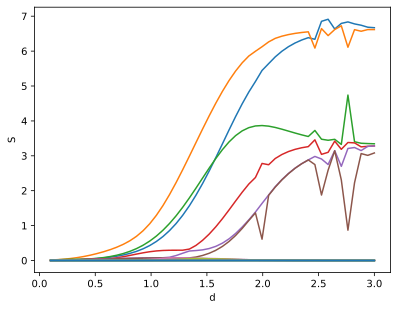

In [ ]:
"""
Para cada autoestado, calculamos la descomposición de Schmidt
"""

prod_dim = basis_up.size           
ds       = sorted(vects)           
res      = np.zeros((len(ds), prod_dim))

for idx, d in tqdm(list(enumerate(ds)), total=len(ds)):
    gs_vec = vects[d]
    # Schmidt decomp
    C = vect_to_tensor_array(gs_vec, basis_r, basis_up)   
    U, s, Vh = np.linalg.svd(C, full_matrices=False)
    V = Vh.conj().T

    # Recontruimos cada uno de los términos de GS |φ_ν⟩ = s_ν Σ_{i,j} U_{iν} V_{jν} |i↑⟩⊗|j↓⟩
    for nu in range(prod_dim):
        phi = np.zeros_like(gs_vec)
        for i in range(prod_dim):
            if U[i, nu] == 0: continue
            for j in range(prod_dim):
                if V[j, nu] == 0: continue
                k = sub2idx[(i, j)] # A qué elemento de la base corresponde?
                phi[k] += s[nu] * U[i, nu] * V[j, nu]

        rho1_nu = rho_m(phi, rho_1_arrays_r)                 
        eig = np.linalg.eigvalsh(rho1_nu.todense()).real
        eig = eig[eig > 1e-12]                   
        res[idx, nu] = -np.sum(eig * np.log2(eig))

plt.xlabel('d')
plt.ylabel('S')
plt.plot(ds, res)

Información mútua

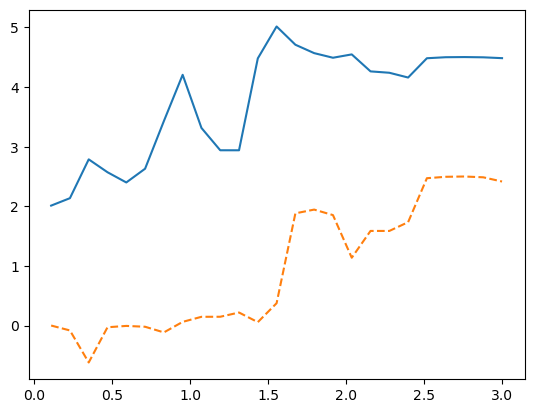

In [ ]:
prod_dim = basis_up.size           
res      = np.zeros(states.shape[1])
res_2      = np.zeros(states.shape[1])

lvl = 2

def S(rho):
    eigvals = np.linalg.eigvalsh(rho)
    return -np.sum([x * np.log2(x) for x in eigvals if x > 1e-6])

for idx in range(states.shape[1]):
    rho = np.array(states[lvl, idx, :])
    rho = np.outer(rho, rho)
    rho_up = vect_to_tensor_array(rho, basis_r, basis_up, up = True)
    rho_down = vect_to_tensor_array(rho, basis_r, basis_up, up = False)

    rho_1_up = rho_m(rho_up, rho_1_arrays).todense()
    rho_1_up *= np.trace(rho_1_up)
    rho_1_down = rho_m(rho_down, rho_1_arrays).todense()
    rho_1_down *= np.trace(rho_1_down)
    rho_2_updown = rho_m(rho, rho_2_extended_updown_as).todense()

    res[idx] = S(rho_up)*np.trace(rho_up) + S(rho_down)*np.trace(rho_down) - S(rho)
    res_2[idx] = S(rho_1_up) + S(rho_1_down) - S(rho_2_updown)


plt.plot(dists, res)
plt.plot(dists, res_2-res_2[0], linestyle='dashed')

In [193]:
dists = np.linspace(0.11, 3.0, 25)

lvls = 3
states = np.zeros(shape=(lvls, len(dists), basis_r.size))
prev_vec = None

for idx, R in enumerate(tqdm(dists, desc="R")):
    H_full, *_ = generate_h2o_hamiltonian(R)

    if H_full is None:
        H_full, *_ = generate_h2o_hamiltonian(R + 1e-4 * np.random.random())
        if H_full is None:
            continue

    H = H_full[np.ix_(basis_r.num_ele, basis_r.num_ele)].real
    if state_type == 'gs':
        E, V = scipy.sparse.linalg.eigsh(H, k=lvls, which='SA', v0=prev_vec, tol=1e-6)
        for l in range(lvls):
            states[l, idx] = V[:, l]
        v0 = V[:, 0]
        prev_vec = v0 / np.linalg.norm(v0)
    else:
        pass

R:  84%|████████▍ | 21/25 [03:24<00:37,  9.38s/it]

R: 100%|██████████| 25/25 [04:30<00:00, 10.81s/it]


In [16]:
1/2*(-37 + 10*np.log2(15))

1.0344529780425944

Negatividad de los distintos bloques

In [72]:
pp_idx = np.zeros((6,441))
for i in range(6):
    pp_idx[i] = np.sum([purity_space[k,i] * eigen_space[:,k] for k in range(12)], axis=0).flatten()

A = np.array(pp_idx).T
opp = A @ np.linalg.inv(A.T @ A) @ A.T

np.round(opp,4)

array([[ 0., -0., -0., ..., -0.,  0.,  0.],
       [-0.,  0.,  0., ...,  0.,  0., -0.],
       [-0.,  0.,  0., ...,  0., -0., -0.],
       ...,
       [-0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0., -0., ..., -0.,  0., -0.],
       [ 0., -0., -0., ...,  0., -0.,  0.]])

In [102]:
diag_elem = np.where(np.abs(opp) > 1e-1)[0]
for i in range(6):
    act_lvls = lambda tt: [tpl[0] for tpl in next(iter(tt.terms.keys()))] # Consistente con lo anterior
    print(6.5-np.array(act_lvls(basis_r.base[diag_elem[i]]))/2)
    #print(basis_r.base[diag_elem[i]])


[6.5 6.  5.  4.  3.5 3.  2.5 1.5 0.5 0. ]
[6.  5.5 5.  4.  3.5 3.  2.5 1.5 0.5 0. ]
[6.  5.  4.5 4.  3.5 3.  2.5 1.5 0.5 0. ]
[6.5 6.  5.5 4.5 3.5 3.  2.  1.  0.5 0. ]
[6.5 5.5 5.  4.5 3.5 3.  2.  1.  0.5 0. ]
[6.5 5.5 4.5 4.  3.5 3.  2.  1.  0.5 0. ]


In [ ]:
U, S, Vh  = np.linalg.svd(local_minima_arr)
idx = np.where(S > 1e-2)
purity_dim = len(idx[0])
purity_space = U[:,idx[0]]

coefs = np.sum([1 * purity_space[:,i] for i in range(purity_dim)], axis=0)
vect = np.sum([coefs[i] * eigen_space[:,i] for i in range(dimension)], axis=0)
vect = np.array(vect).flatten()
vect *= 1/np.linalg.norm(vect)


# Construimos la base reduciuda y la matriz C
C = vect_to_tensor_array(basis, vect)

# Arrancamos rotando a la base natural
rho_up = C @ np.transpose(C)
rho_down = np.transpose(C) @ C

#rho = rho_m(vect, rho_2_extended_updown)
#rho = partial_traspose(rho, [0, 3, 2, 1]) 
#print(np.sort(np.linalg.eigvals(rho)))



In [ ]:
def decomp(coefs):
    coefs = np.sum([coefs[i] * purity_space[:,i] for i in range(purity_dim)], axis=0)
    vect = np.sum([coefs[i] * eigen_space[:,i] for i in range(dimension)], axis=0)
    vect = vect.T[0]
    vect *= 1/np.linalg.norm(vect)
    rho_1 = rho_m(vect, rho_1_arrays_r).todense()
    return 1-np.trace(np.linalg.matrix_power(rho_1, 2))

opt2 = scipy.optimize.minimize(decomp, np.random.rand(purity_dim))
ooo = opt2.x
print(opt2)
ooo *= 1/np.linalg.norm(ooo)
print(ooo)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -8.999999778160634
        x: [ 1.041e+00  1.335e+00  2.288e-06  5.717e-01  7.936e-07
            -6.305e-07]
      nit: 6
      jac: [ 0.000e+00  4.768e-07  7.153e-07  0.000e+00  4.768e-07
            -8.345e-07]
 hess_inv: [[ 1.274e+00  3.514e-01 ... -6.656e-02 -1.304e-02]
            [ 3.514e-01  1.451e+00 ... -8.613e-02 -1.564e-02]
            ...
            [-6.656e-02 -8.613e-02 ...  4.171e-01  2.714e-01]
            [-1.304e-02 -1.564e-02 ...  2.714e-01  5.390e-01]]
     nfev: 77
     njev: 11
[ 5.82635519e-01  7.47071848e-01  1.28071271e-06  3.20030477e-01
  4.44251153e-07 -3.52981057e-07]


Transpuesta parcial sobre el proyector al autoespacio. Recordar que utilizamos la convención de OF, donde los índices pares son UP y los impares DOWN

In [ ]:
from sympy.combinatorics import Permutation



# Reescribimos los elementos de la base en términos de productos tensorial
up_lvls = []
down_lvls = []
act_lvls = lambda tt: np.array([tpl[0] for tpl in next(iter(tt.terms.keys()))])
for op in basis_r.base:
    up_lvls.append(tuple(sorted(l for l in act_lvls(op) if l % 2 == 0)))
    down_lvls.append(tuple(sorted(l for l in act_lvls(op) if l % 2 == 1)))

# Filtramos los elemetos únicos, obteniendo la base de un lado del producto tensorial
u_up_lvls = np.array(list(set(up_lvls)))
u_down_lvls = np.array(list(set(down_lvls)))

# Obtenemos la matrix C_{\mu\nu}
def tensor_decomp(state):
    s = len(u_up_lvls)
    C = np.zeros((s,s))
    act_to_int = lambda x: np.sum([2**i for i in x])
    for i, j in itertools.product(range(s), repeat=2):
        targ_state_pre = np.concatenate([u_up_lvls[i], u_down_lvls[j]])
        targ_state = tuple(sorted(targ_state_pre))
        r_idx = np.where(basis_r.num_ele == act_to_int(targ_state))[0]
        # Calculamos el signo de la permutación al sortearlos
        perm = np.argsort(targ_state_pre)
        p = Permutation(list(perm))
        sign = p.signature()
        C[i, j] = sign * state[r_idx]

    return C

def partial_transpose(C):
    s = len(u_up_lvls)
    res = np.zeros((s**2,s**2))
    for mu, nu, mup, nup in itertools.product(range(s), repeat=4):
        i = s * mu + nu
        j = s * mup + nup
        res[i, j] = C[mu, nup] * C[mup, nu]
    return res

pt = lambda x: partial_transpose(tensor_decomp(x))
mat = np.sum([pt(eigen_space[:,i]) for i in range(dimension)], axis=0)
np.sort(np.linalg.eigvals(mat))

/tmp/ipykernel_36865/1646309796.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C[i, j] = sign * state[r_idx]


array([-9.99999916e-01, -9.99999916e-01, -1.87175042e-04, -1.87171684e-04,
       -1.73404358e-04, -1.73238279e-04, -1.64250726e-04, -1.63960241e-04,
       -9.84856530e-05, -9.82899512e-05, -9.78538435e-05, -9.77073882e-05,
       -9.68740766e-05, -9.68719231e-05, -8.21697720e-05, -8.21690267e-05,
       -7.83072212e-05, -7.83010724e-05, -7.42543531e-05, -7.42281399e-05,
       -1.24041319e-05, -1.21150203e-05, -1.07390199e-05, -1.05004889e-05,
       -6.70333511e-06, -6.34326468e-06, -5.99758925e-06, -5.97232319e-06,
       -5.37842435e-06, -5.36733577e-06, -4.65190701e-06, -4.30078724e-06,
       -1.14180677e-06, -1.14012386e-06, -9.11831809e-07, -9.01436774e-07,
       -7.13688950e-07, -7.04671947e-07, -5.03235337e-07, -5.03204819e-07,
       -5.03101015e-07, -5.02740112e-07, -5.02437031e-07, -5.00583784e-07,
       -4.49978505e-07, -4.48570345e-07, -4.41402278e-07, -4.35850725e-07,
       -4.30319891e-07, -4.29443585e-07, -3.07377998e-07, -2.85751367e-07,
       -2.11721309e-07, -

# Misc

Opt global

In [3]:
ds = list(vects.keys())[::10]
res = np.zeros(shape=(len(ds),3))
for idx, d in tqdm(enumerate(ds), total=len(ds)):
    loss = lambda au: np.linalg.norm(au, 1)
    vect = vects[d]
    # Estado sin transformar
    C = vect_to_tensor_array(basis, vect)
    res[idx,0] = loss(C)
    # Estado en base natural
    rho_up = C @ np.transpose(C)
    rho_down = np.transpose(C) @ C
    rho_1_up = rho_m(rho_up, rho_1_arrays)
    rho_1_down = rho_m(rho_down, rho_1_arrays)
    V_up = natural_basis_rotation(basis, rho_1 = rho_1_up)
    V_down = natural_basis_rotation(basis, rho_1 = rho_1_down)
    Cn = V_up @ C @ V_down.T
    res[idx,1] = loss(Cn)
    # Optimizamos
    expt_len = basis.d * (basis.d + 1) // 2
    triu_rows, triu_cols = np.triu_indices(basis.d)
    init_seed_up, init_seed_down = V_up[triu_rows, triu_cols], V_down[triu_rows, triu_cols]
    init_seed = np.concatenate([init_seed_up, init_seed_down])
    opt = scipy.optimize.minimize(opti_fun, init_seed, method='L-BFGS-B', options={'disp': True}, args=(C, basis))
    seed = opt.x
    seed_up, seed_down = seed[:expt_len], seed[expt_len:]
    Vop_up, Vop_down = seed_to_rotation(seed_up), seed_to_rotation(seed_down)
    Cop = Vop_up @ C @ Vop_down.T
    res[idx,2] = loss(Cop)

res = res.T

NameError: name 'vects' is not defined

In [ ]:
import matplotlib.pyplot as plt
res = res.T
plt.pyplot.plot(ds, res[0], label='Estado')
plt.pyplot.plot(ds, res[1], label='Base natural')
plt.pyplot.plot(ds, res[2], label='Optimizado')
plt.pyplot.legend()

AttributeError: module 'matplotlib.pyplot' has no attribute 'pyplot'

In [ ]:
norm1 = lambda au: np.sum(np.abs(au))
norm2 = lambda au: np.max

In [ ]:
def cost(au):
    return np.linalg.norm(au, ord=1)

In [ ]:
cost(C), cost(Cn), cost(Cop)

(0.6692917507771787, 0.6030561514836338, 0.6050418638279407)

In [ ]:
np.trace(rhoo_up)

1.0000000406850609

Veamos que ocurre ahora con la matriz de coeficientes

In [ ]:
cost = lambda au: np.max(np.sum(np.abs(au), axis=0))

In [ ]:
cost(C), cost(Cn), cost(Cop)

(0.6692917507771787, 0.9191059397990166, 0.5485164931466948)

In [ ]:
np.round(Cn,5).nonzero(), np.round(C,5).nonzero()

((array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
          5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
         11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14,

In [ ]:
np.linalg.norm(rho_up-rhon_up), np.linalg.norm(rho_up-rhoo_up)

(0.34206023774207855, 0.015398804494478627)

In [ ]:
Cn

array([[-9.28164239e-03, -4.46010991e-02,  1.98770844e-03,
         1.12637076e-03,  4.83222874e-02,  2.09218992e-01,
        -6.87161227e-06, -2.94053351e-04,  9.19167665e-05,
        -8.81515231e-08,  9.98141372e-04,  4.44739298e-02,
         1.92547642e-01, -2.00574483e-04,  1.30140475e-06,
        -6.19631382e-06, -2.65156436e-04,  8.22383181e-05,
        -7.95612501e-08,  3.86674330e-11, -1.17359343e-06],
       [-2.02232733e-03,  1.43622010e-04,  2.09550437e-03,
         2.12130637e-01,  4.88637137e-03, -6.34054817e-04,
        -5.86450796e-05,  5.12685543e-06, -1.60728233e-07,
        -6.43177712e-04,  1.95228994e-01,  4.49727492e-03,
        -5.92258989e-04, -2.58660179e-05,  5.91937808e-04,
        -5.40017757e-05,  4.60137264e-06, -1.41186830e-07,
        -5.78547571e-04, -5.65948653e-07, -5.32456614e-04],
       [-4.55575504e-02,  3.96083234e-03, -2.62208130e-04,
         4.87186654e-03,  4.21116237e-01, -2.71044864e-02,
         2.21344247e-06,  3.59376282e-05, -6.51758419e

In [ ]:
np.round(rhon_up,3)

array([[ 0.086,  0.001,  0.024, -0.016, -0.   ,  0.001,  0.   ,  0.   ,
        -0.   ,  0.   , -0.   ,  0.   , -0.   , -0.   ,  0.   , -0.   ,
        -0.   ,  0.   ,  0.   , -0.   ,  0.   ],
       [ 0.001,  0.083,  0.001, -0.007,  0.001, -0.   , -0.   , -0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,
         0.   , -0.   , -0.   ,  0.   , -0.   ],
       [ 0.024,  0.001,  0.332,  0.   , -0.002,  0.002,  0.   ,  0.   ,
        -0.   ,  0.   , -0.   , -0.   ,  0.   ,  0.   , -0.   , -0.   ,
         0.   ,  0.   , -0.   ,  0.   , -0.   ],
       [-0.016, -0.007,  0.   ,  0.333,  0.005, -0.   ,  0.   , -0.   ,
        -0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.001, -0.002,  0.005,  0.083, -0.001, -0.   ,  0.   ,
        -0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,
         0.   , -0.   ,  0.   , -0.   ,  0.   ],
       [ 0.001, -0.   ,  0.002, -0.

In [ ]:
"""
Algunos casos de ejemplo para ver de como funciona la rotación de bases
"""
# Construimos la base reduciuda y la matriz C
C = vect_to_tensor_array(basis, vect)
# Calculamos las matrices de densidad reducidas UP, DOWN
rho_up = C @ np.transpose(C)
rho_down = np.transpose(C) @ C
# Calculo matrices densidad 1 cuerpo
rho_1_arrays = rho_m_gen(basis, 1)
rho_1_up = rho_m(rho_up, rho_1_arrays)
rho_1_down = rho_m(rho_down, rho_1_arrays)

V_up = natural_basis_rotation(basis, rho_1_up, rho_up)
rhot_up = V_up @ rho_up @ V_up.T
V_down = natural_basis_rotation(basis, rho_1_down, rho_down)
rhot_down = V_down @ rho_down @ V_down.T

np.linalg.eigvals(rho_m(rhot_up, rho_1_arrays).todense()), np.linalg.eigvals(rho_m(rhot_down, rho_1_arrays).todense())

100%|██████████| 21/21 [00:00<00:00, 23.98it/s]


(array([0.47487306, 0.52513204, 0.4806496 , 0.51935319, 0.99999489,
        0.99999739, 1.00000004]),
 array([0.47487306, 0.52513204, 0.4806496 , 0.51935319, 0.99999489,
        0.99999739, 1.00000004]))

In [33]:
basis_c.m

10

In [ ]:
print(opt)
print(opt.x)
print(sparsity_error(opt.x, k=k))
print(rho_2_obj)
np.round(r_eig(rho_m(opt.x, rho_2_arrays)),2)

  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: 0.033046434440661125
        x: [-3.375e-09 -6.560e-09 ... -2.341e-06 -2.501e-01]
      nit: 6
      jac: [ 2.845e-08 -2.429e-08 ... -3.317e-05 -3.462e-03]
     nfev: 16570
     njev: 10
 hess_inv: <1656x1656 LbfgsInvHessProduct with dtype=float64>
[-3.37476985e-09 -6.55962993e-09 -2.46507721e-09 ... -3.19263831e-09
 -2.34107673e-06 -2.50086415e-01]
0.03302971629150185
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11,
       0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11,
       0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.33, 0.33, 0.33, 0.33, 0.33,
       0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33,
       0.33, 0.33, 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.67, 0.67, 0.67, 0.67, 0.67,
       0.67, 0.67, 0.67, 0.67, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

In [ ]:
final_res = of.FermionOperator.zero()

tol = 1e-3
for idx, coord in enumerate(opt.x):
    final_res += basis_pro.base[idx] * coord if np.abs(coord) > tol else 0
    if np.abs(coord) > tol:
        print((1/np.abs(coord)**2))

#final_res, unique_ele(final_res)
res_round = np.sum([basis_pro.base[idx] * 1/np.sqrt(np.round(1/coord**2)) for idx, coord in enumerate(opt.x) if np.abs(coord) > tol])
vect_round = op_to_rep(basis_pro, res_round)
r_eig(rho_m(vect_round, rho_1_arrays)), rho_1_obj


15.985149014125556
15.977994228992863
145.67794611307684
144.23635285020111
36.0667153166155
36.06669576174053
144.236519674107
145.67809058988465
15.940732217777308
15.92062248719232
36.06161200056504
144.19110686510734
145.6825136168376
144.3651909188651
36.137913817300415
144.15515590265179
36.08996734303805
146.12453205723767
145.9487386480123
36.0045807486866
143.95252252055505
145.46009050066652
145.68262967629167
144.19109509086093
36.06156842879171
146.12428332738412
145.94902938020775
36.13796198870655
144.36575578324243
36.089955665595035
144.15460190992823
145.46007040730746
143.95261481327165
36.00458940655681
15.941719440781728
15.91950923819659
145.45631237154984
143.99620720608377
36.00963579334049
36.009636612591606
143.99642927360614
145.45649058176977
15.951017099193605
15.988944628712272


(array([0.49947646, 0.49947646, 0.49947646, 0.49947646, 0.4995237 ,
        0.4995237 , 0.4995237 , 0.4995237 , 0.49957093, 0.49957093,
        0.49957093, 0.49957093, 0.99904739, 0.99904739, 0.99904739,
        0.99904739]),
 array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. ,
        1. , 1. , 1. ]))

#### Testing

Verificamos que los eig de rho1 se preservan

In [ ]:
# Cálculo de base natural
rho_1_arrays = rho_m_gen(basis, 1)
rho_1 = rho_m(vect, rho_1_arrays).todense()
evals, evects = scipy.linalg.eigh(rho_1)
C = evects

res, vect_op_ft = natural_basis_rotation(basis, C, vect)

ext_basis = FixedBasis(basis.d, basis.m)
rho_1_arrays_n = rho_m_gen(ext_basis, 1, num_workers=32)
rho_1_n = rho_m(res, rho_1_arrays_n).todense()
print(np.trace(rho_1_n), np.trace(rho_1))

evv = lambda vv: np.sort(np.real(np.linalg.eigvals(vv)))
print(evv(rho_1), evv(rho_1_n))

rep_to_op = lambda vect: np.sum([vect[i] * basis.base[i] for i in range(len(vect))])
#unique_ele(vect_op_ft), unique_ele(rep_to_op(vect))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:49<00:00,  1.54s/it]


10.000000000000002 10.000000406850612
[0.         0.         0.47487306 0.47487306 0.4806496  0.4806496
 0.51935319 0.51935319 0.52513204 0.52513204 0.99999489 0.99999489
 0.99999739 0.99999739 1.00000004 1.00000004] [0.         0.         0.47487306 0.47487306 0.48064955 0.48064955
 0.51935319 0.51935319 0.525132   0.525132   0.99999485 0.99999485
 0.99999735 0.99999735 1.         1.        ]


Verificamos que la composición, es la identidad

In [ ]:
res, vect_op_ft = natural_basis_rotation(basis, C, vect)
res2, vect_op_ft2 = natural_basis_rotation(ext_basis, C.T, res)

vect_op = np.sum([vect[i] * basis.base[i] for i in range(len(vect))])

of.transforms.normal_ordered(vect_op_ft2), res2, of.transforms.normal_ordered(vect_op)

(-0.009493221505521588 [11^ 10^ 9^ 8^ 7^ 4^ 3^ 2^ 1^ 0^] +
 0.06567915392863352 [11^ 10^ 9^ 8^ 7^ 5^ 4^ 2^ 1^ 0^] +
 -0.00039479040463999686 [11^ 10^ 9^ 8^ 7^ 5^ 4^ 3^ 2^ 0^] +
 -3.372243029427183e-06 [11^ 10^ 9^ 8^ 7^ 5^ 4^ 3^ 2^ 1^] +
 -0.046493134167591176 [11^ 10^ 9^ 8^ 7^ 6^ 3^ 2^ 1^ 0^] +
 -0.28426333153569405 [11^ 10^ 9^ 8^ 7^ 6^ 5^ 2^ 1^ 0^] +
 -0.00013174919476567257 [11^ 10^ 9^ 8^ 7^ 6^ 5^ 3^ 2^ 0^] +
 3.4219639201432875e-07 [11^ 10^ 9^ 8^ 7^ 6^ 5^ 3^ 2^ 1^] +
 0.002101619231354521 [12^ 10^ 9^ 8^ 7^ 5^ 3^ 2^ 1^ 0^] +
 0.2881444085777637 [12^ 10^ 9^ 8^ 7^ 6^ 4^ 2^ 1^ 0^] +
 -7.974636812387609e-05 [12^ 10^ 9^ 8^ 7^ 6^ 4^ 3^ 2^ 0^] +
 -2.402101031541447e-06 [12^ 10^ 9^ 8^ 7^ 6^ 4^ 3^ 2^ 1^] +
 0.0011760974915812092 [12^ 10^ 9^ 8^ 7^ 6^ 5^ 4^ 2^ 0^] +
 8.012654141343571e-06 [12^ 10^ 9^ 8^ 7^ 6^ 5^ 4^ 2^ 1^] +
 5.654427524408164e-07 [12^ 10^ 9^ 8^ 7^ 6^ 5^ 4^ 3^ 2^] +
 0.06567916523926123 [12^ 11^ 9^ 8^ 7^ 4^ 3^ 2^ 1^ 0^] +
 0.00389332162644885 [12^ 11^ 9^ 8^ 7^ 5^ 4^ 2^ 1^ 0^] +


Funciones auxiliares

In [ ]:
def unique_ele(op):
    terms = list(op.terms.items())
    act_idx = lambda tt: [i[0] for i in tt[0]]
    terms_set = []
    for term in terms:
        if np.abs(term[1]) > 1e-6:
            terms_set.append(act_idx(term))
    return set(terms_set[0]).intersection(*terms_set[1:])

unique_ele(op_pro), unique_ele(op_fund)

(set(), set())

In [ ]:
np.linalg.eigvals(rho_1)

array([0.97351211, 0.92118047, 0.31511585, 0.31511585, 0.79019157,
       0.79019157, 1.        , 0.97351211, 0.92118047, 1.        ,
       1.        , 1.        ])

In [ ]:
# Verifiquemos que los orbitales son ortogonales
op_arr = np.zeros((basis.d,basis.d),dtype=object)
sp_basis = FixedBasis(basis.d, 1)
for i in tqdm(range(basis.d)):
    for j in range(basis.d):
        oi = np.real(of.get_sparse_operator(targ_sp[i], n_qubits=basis.d))
        oj = np.real(of.get_sparse_operator(targ_sp[j], n_qubits=basis.d))
        # Sin daguear y dagueado
        assert len((oi * oj + oj * oi).data) == 0
        assert len((oi.T * oj.T + oj.T * oi.T).data) == 0
        # Términos cruzados
        op_arr[i,j] = oi * oj.T + oj.T * oi
        sh = op_arr[i,j].shape[0]
        if i != j:
            assert np.allclose(np.zeros((sh,sh)),op_arr[i,j].todense())
        else:
            assert np.allclose(np.eye(sh),op_arr[i,j].todense())

100%|██████████| 12/12 [01:00<00:00,  5.07s/it]


In [ ]:
est = 0
app_r = lambda x: np.round(1/(x**2), 0)
for i, ii in enumerate(opt.x):
    if np.abs(ii) > 0.1:
        print(i, ii, basis.base[i])
        if np.abs(ii) > 0.2:
            print(app_r(ii))
            est += 1/np.sqrt(app_r(ii)) * basis.canonicals[i]
            print('')

#(1/np.sqrt(3), 1/np.sqrt(12))
#print(est)
est = 1/np.sqrt(12) * (-basis.canonicals[5]+basis.canonicals[25]+basis.canonicals[85]-basis.canonicals[105])+1/np.sqrt(3)*(basis.canonicals[45]+basis.canonicals[65])

print(r_eig(rho_m(est, rho_2_arrays)))


5 -0.27936976320734497 1.0 [0^ 1^ 2^ 3^ 4^ 7^ 8^ 9^ 12^ 13^]
13.0

25 0.28996316812175205 1.0 [0^ 1^ 2^ 3^ 5^ 7^ 8^ 9^ 11^ 13^]
12.0

45 0.5718530568911167 1.0 [0^ 1^ 2^ 3^ 6^ 7^ 8^ 9^ 11^ 12^]
3.0

65 0.572154480816062 1.0 [0^ 1^ 2^ 4^ 5^ 7^ 8^ 9^ 10^ 13^]
3.0

85 0.2897326805359033 1.0 [0^ 1^ 2^ 4^ 6^ 7^ 8^ 9^ 10^ 12^]
12.0

105 -0.27954194550717076 1.0 [0^ 1^ 2^ 5^ 6^ 7^ 8^ 9^ 10^ 11^]
13.0

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.5
 0.5        0.5        0.5        0.5        0

In [ ]:
r_eig(rho_m(vect, rho_2_arrays))

array([6.39649654e-18, 2.27759896e-17, 2.27759896e-17, 2.97340303e-17,
       1.05847838e-08, 1.05847839e-08, 8.12469946e-02, 8.12469946e-02,
       8.12469946e-02, 8.12469946e-02, 8.12469946e-02, 8.12469946e-02,
       8.26670825e-02, 8.26670825e-02, 8.26670825e-02, 8.26670825e-02,
       8.26670825e-02, 8.26670825e-02, 3.36085923e-01, 3.36085923e-01,
       3.36085923e-01, 3.36085923e-01, 3.36085923e-01, 3.36085923e-01,
       7.48001237e-01, 7.48001237e-01, 7.51998753e-01, 7.51998753e-01])

#### Testing

In [ ]:
vect = [-4.646928018967011e-01,2.770294629368069e-13,6.042253100720720e-13,-6.024516357133285e-13,-2.567187786718633e-13,1.437594192304828e-01,-2.763730452330614e-13,4.646928018967681e-01,6.783135520862164e-13,6.755585098225312e-13,-1.437594192304206e-01,2.565069368880155e-13,-6.036534951757788e-13,-6.777043000828106e-13,-6.255919748617283e-14,-2.875188384604817e-01,-6.292320178844996e-13,-5.606330583371935e-13,6.014298958703158e-13,-6.759194003610720e-13,-2.875188384604817e-01,-6.207393804663961e-14,-6.269833844031960e-13,5.590088393571927e-13,2.557458444682729e-13,-1.437594192304207e-01,6.287588334290853e-13,6.270036860946324e-13,4.000749631766127e-01,-2.383049928519640e-13,1.437594192304827e-01,-2.559215089660516e-13,5.600763473792744e-13,-5.580405389843103e-13,2.382296361695720e-13,-4.000749631765536e-01]
vect = np.array(vect)
vect

array([-4.64692802e-01,  2.77029463e-13,  6.04225310e-13, -6.02451636e-13,
       -2.56718779e-13,  1.43759419e-01, -2.76373045e-13,  4.64692802e-01,
        6.78313552e-13,  6.75558510e-13, -1.43759419e-01,  2.56506937e-13,
       -6.03653495e-13, -6.77704300e-13, -6.25591975e-14, -2.87518838e-01,
       -6.29232018e-13, -5.60633058e-13,  6.01429896e-13, -6.75919400e-13,
       -2.87518838e-01, -6.20739380e-14, -6.26983384e-13,  5.59008839e-13,
        2.55745844e-13, -1.43759419e-01,  6.28758833e-13,  6.27003686e-13,
        4.00074963e-01, -2.38304993e-13,  1.43759419e-01, -2.55921509e-13,
        5.60076347e-13, -5.58040539e-13,  2.38229636e-13, -4.00074963e-01])

In [ ]:
np.sort(np.linalg.eigvals(rho_m(vect, rho_2_arrays).todense()))

array([6.39649654e-18+0.00000000e+00j, 2.27759896e-17-1.60872919e-17j,
       2.27759896e-17+1.60872919e-17j, 2.97340303e-17+0.00000000e+00j,
       1.05847838e-08+0.00000000e+00j, 1.05847839e-08+0.00000000e+00j,
       8.12469946e-02+0.00000000e+00j, 8.12469946e-02+0.00000000e+00j,
       8.12469946e-02+0.00000000e+00j, 8.12469946e-02+0.00000000e+00j,
       8.12469946e-02+0.00000000e+00j, 8.12469946e-02+0.00000000e+00j,
       8.26670825e-02+0.00000000e+00j, 8.26670825e-02+0.00000000e+00j,
       8.26670825e-02+0.00000000e+00j, 8.26670825e-02+0.00000000e+00j,
       8.26670825e-02+0.00000000e+00j, 8.26670825e-02+0.00000000e+00j,
       3.36085923e-01+0.00000000e+00j, 3.36085923e-01+0.00000000e+00j,
       3.36085923e-01+0.00000000e+00j, 3.36085923e-01+0.00000000e+00j,
       3.36085923e-01+0.00000000e+00j, 3.36085923e-01+0.00000000e+00j,
       7.48001237e-01+0.00000000e+00j, 7.48001237e-01+0.00000000e+00j,
       7.51998753e-01+0.00000000e+00j, 7.51998753e-01+0.00000000e+00j])